✅ Dataset Loaded: 16722 rows × 22 numeric features


,PM2.5,PM10,NO2,O3,CO,SO2,pm25_si,pm10_si,AQI,hour,...,AQI_lag1,AQI_lag2,AQI_lag3,AQI_lag6,AQI_lag12,AQI_lag24,AQI_roll3,AQI_roll6,AQI_roll12,AQI_roll24
Datetime,,,,,,,,,,,,,,,,,,,,,
2018-05-08 12:00:00,28.13,65.01,21.97,36.09,1.27,18.46,46.883333,65.01,65.01,12,...,26.583333,38.150000,32.083333,32.766667,31.216667,12.933333,43.247778,39.104444,29.832778,32.900244
2018-05-08 13:00:00,16.17,57.70,19.54,35.62,1.23,17.64,26.950000,57.70,57.70,13,...,65.010000,26.583333,38.150000,36.333333,7.866667,21.100000,49.764444,42.665556,33.985556,34.425244
2018-05-08 14:00:00,10.38,43.03,16.31,33.86,1.19,17.91,17.300000,43.03,43.03,14,...,57.700000,65.010000,26.583333,36.466667,22.816667,33.250000,55.246667,43.759444,35.670000,34.832744
2018-05-08 15:00:00,16.66,48.35,16.51,29.43,1.19,19.37,27.766667,48.35,48.35,15,...,43.030000,57.700000,65.010000,32.083333,18.100000,20.533333,49.693333,46.470556,38.190833,35.991772
2018-05-08 16:00:00,18.48,43.90,19.00,31.00,1.19,17.90,30.800000,43.90,43.90,16,...,48.350000,43.030000,57.700000,38.150000,21.950000,22.950000,45.093333,47.428889,40.020000,36.864689


📊 Training samples: 11705, Testing samples: 5017
🔎 Baseline Results: {'Persistence': np.float64(18.066870491124764), 'Moving Average (24h)': np.float64(34.21910619621573)}
🚀 Training Models...


,Model,RMSE,MAE,R²
2,Random Forest,0.685920,0.220102,0.999906
3,XGBoost,2.605317,1.023717,0.998644
0,Persistence,18.066870,NaN,NaN
1,Moving Average (24h),34.219106,NaN,NaN


✅ Best model saved as model_artifact.pkl (Random Forest)


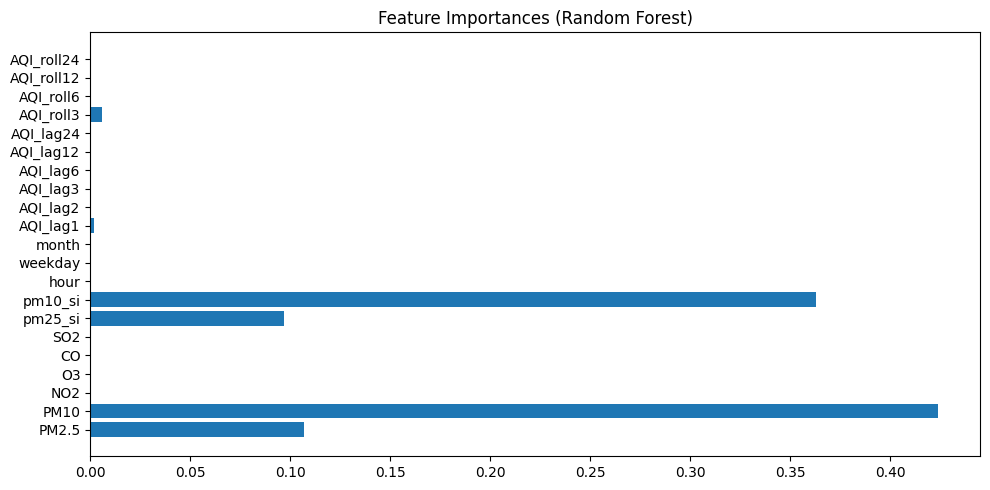

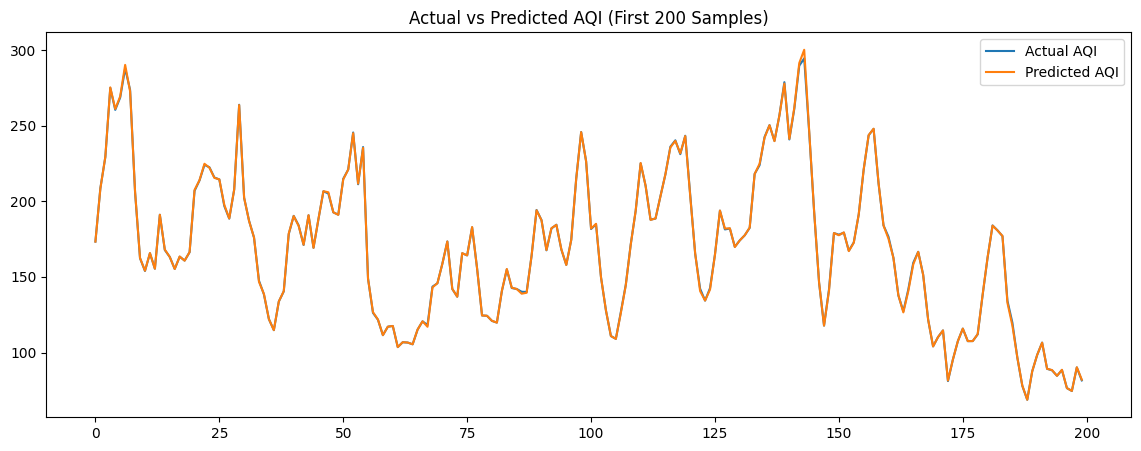

In [1]:
# ---------------------------------------------------
# Clean-Air Companion: Week 3 Final Notebook
# ---------------------------------------------------
# 1) Loads pre-engineered AQI features
# 2) Trains & evaluates models
# 3) Saves model + feature list as artifact for deployment
# ---------------------------------------------------

# STEP 1: Imports
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, joblib, json, os, time
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# STEP 2: Load & Preprocess AQI Data
if os.path.exists("aqi_features.csv"):
    df = pd.read_csv("aqi_features.csv", index_col=0, parse_dates=True)
else:
    raise FileNotFoundError("aqi_features.csv not found. Please run Week 2 notebook first.")

# Drop non-numeric columns
df = df.select_dtypes(include='number')
print(f"✅ Dataset Loaded: {df.shape[0]} rows × {df.shape[1]} numeric features")
display(df.head())

# STEP 3: Train-Test Split
split_idx = int(len(df) * 0.7)
train, test = df.iloc[:split_idx], df.iloc[split_idx:]
X_train, y_train = train.drop(columns=['AQI']), train['AQI']
X_test, y_test = test.drop(columns=['AQI']), test['AQI']
print(f"📊 Training samples: {len(X_train)}, Testing samples: {len(X_test)}")

# STEP 4: Baseline Models
baseline_results = {}
if 'AQI_lag1' in test.columns:
    baseline_results["Persistence"] = np.sqrt(mean_squared_error(y_test, test['AQI_lag1']))
if 'AQI_roll24' in test.columns:
    baseline_results["Moving Average (24h)"] = np.sqrt(mean_squared_error(y_test, test['AQI_roll24']))
print("🔎 Baseline Results:", baseline_results)

# STEP 5: Machine Learning Models
print("🚀 Training Models...")
rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

xgb = XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=6, random_state=42, n_jobs=-1)
xgb.fit(X_train, y_train)
xgb_preds = xgb.predict(X_test)

# Metrics
rf_rmse, xgb_rmse = np.sqrt(mean_squared_error(y_test, rf_preds)), np.sqrt(mean_squared_error(y_test, xgb_preds))
rf_mae, xgb_mae = np.mean(np.abs(y_test - rf_preds)), np.mean(np.abs(y_test - xgb_preds))
rf_r2, xgb_r2 = r2_score(y_test, rf_preds), r2_score(y_test, xgb_preds)

results = pd.DataFrame({
    "Model": list(baseline_results.keys()) + ["Random Forest", "XGBoost"],
    "RMSE": list(baseline_results.values()) + [rf_rmse, xgb_rmse],
    "MAE": [np.nan, np.nan, rf_mae, xgb_mae],
    "R²": [np.nan, np.nan, rf_r2, xgb_r2]
}).sort_values(by="RMSE")
display(results)

# STEP 6: Save Best Model + Artifact
best_model = rf if rf_rmse < xgb_rmse else xgb
best_name = "Random Forest" if best_model == rf else "XGBoost"

artifact = {
    "model_name": best_name,
    "created_at": time.strftime("%Y-%m-%d %H:%M:%S"),
    "feature_names": X_train.columns.tolist(),
    "medians": X_train.median().to_dict()
}
joblib.dump({"model": best_model, "meta": artifact}, "model_artifact.pkl")
with open("model_manifest.json", "w") as f: json.dump(artifact, f, indent=2)

print(f"✅ Best model saved as model_artifact.pkl ({best_name})")

# STEP 7: Visualizations
if best_name == "Random Forest":
    importances = best_model.feature_importances_
    plt.figure(figsize=(10,5))
    plt.barh(X_train.columns, importances)
    plt.title("Feature Importances (Random Forest)")
    plt.tight_layout()
    plt.show()

best_preds = rf_preds if best_model == rf else xgb_preds
plt.figure(figsize=(14,5))
plt.plot(y_test.values[:200], label='Actual AQI')
plt.plot(best_preds[:200], label='Predicted AQI')
plt.legend(); plt.title("Actual vs Predicted AQI (First 200 Samples)")
plt.show()
